Block size = 1 x 1  ->  Time taken = 0.076781 sec
Block size = 2 x 2  ->  Time taken = 0.000548 sec
Block size = 4 x 4  ->  Time taken = 0.000116 sec
Block size = 8 x 8  ->  Time taken = 0.000085 sec
Block size = 12 x 12  ->  Time taken = 0.000080 sec
Block size = 16 x 16  ->  Time taken = 0.000112 sec
Block size = 20 x 20  ->  Time taken = 0.000080 sec
Block size = 24 x 24  ->  Time taken = 0.000074 sec
Block size = 28 x 28  ->  Time taken = 0.000097 sec
Block size = 32 x 32  ->  Time taken = 0.000086 sec


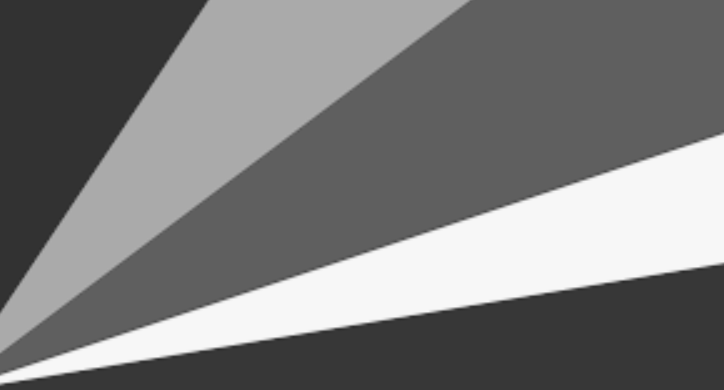

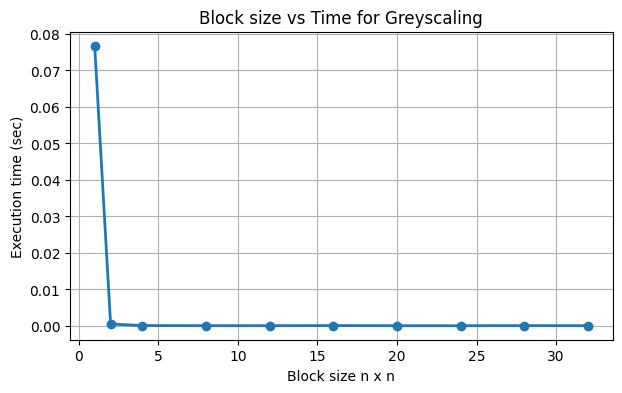


VALUE FOR MINIMUM AND MAXIMUM
Minimum value: 42.0
Maximum value: 247.0

Block size = 1 x 1  ->  Time taken = 0.063895 sec
Block size = 2 x 2  ->  Time taken = 0.000520 sec
Block size = 4 x 4  ->  Time taken = 0.000152 sec
Block size = 8 x 8  ->  Time taken = 0.000111 sec
Block size = 12 x 12  ->  Time taken = 0.000108 sec
Block size = 16 x 16  ->  Time taken = 0.000157 sec
Block size = 20 x 20  ->  Time taken = 0.000110 sec
Block size = 24 x 24  ->  Time taken = 0.000153 sec
Block size = 28 x 28  ->  Time taken = 0.000147 sec
Block size = 32 x 32  ->  Time taken = 0.000090 sec


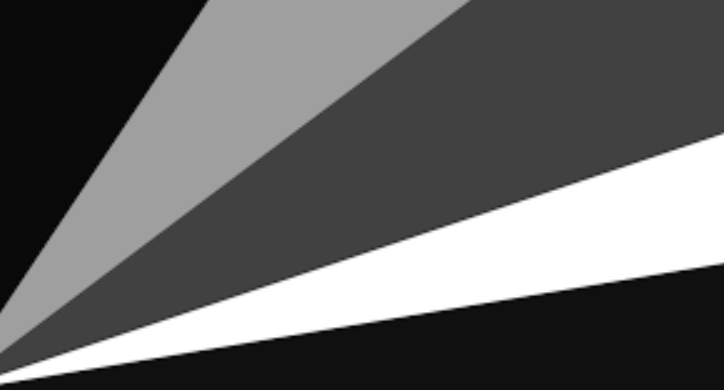

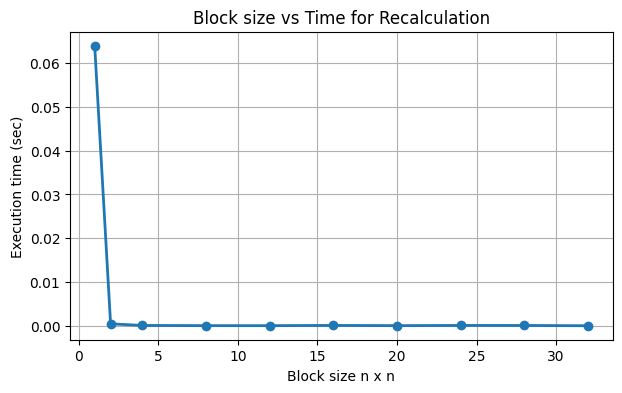

In [46]:
#### Grey stretch ####

from PIL import Image
import time
import numpy as np
from numba import cuda, config
import matplotlib.pyplot as plt
config.CUDA_ENABLE_PYNVJITLINK = 1

# Function to convert in a grey image
@cuda.jit   # For GPU
def greyscale_gpu(src, dst):
    tidx1, tidx2 = cuda.grid(2)
    if tidx1 < src.shape[0] and tidx2 < src.shape[1]: # Image limit
        r = src[tidx1, tidx2, 0]
        g = src[tidx1, tidx2, 1]
        b = src[tidx1, tidx2, 2]
        gy = np.uint8((r + g + b) / 3)  # Average of pixels
        dst[tidx1, tidx2] = gy # The 3 pixels become grey

# Function to find min max
@cuda.jit
def min_max(src, min_array, max_array):
    # shared memory declaration for caching block content
    shared_size = cuda.shared.array((256,), dtype=np.float32)
    local_min = cuda.shared.array((256,), dtype=np.float32)
    local_max = cuda.shared.array((256,), dtype=np.float32)
    tid = cuda.grid(1)

    # Load data in shared memory
    if tid < src.size:
        shared_size[cuda.threadIdx.x] = src[tid]
    else:
        shared_size[cuda.threadIdx.x] = float('inf')
    cuda.syncthreads()

    # Minimum
    s = cuda.blockDim.x // 2
    while s > 0:
        if cuda.threadIdx.x < s:
            shared_size[cuda.threadIdx.x] = min(shared_size[cuda.threadIdx.x], shared_size[cuda.threadIdx.x + s])
        cuda.syncthreads()
        s //= 2
    if cuda.threadIdx.x == 0: # only first thread writes back to dst
        min_array[cuda.blockIdx.x] = shared_size[0]

    # Load data in shared memory again
    if tid < src.size:
        shared_size[cuda.threadIdx.x] = src[tid]
    else:
        shared_size[cuda.threadIdx.x] = float('-inf')
    cuda.syncthreads()

    # Maximum
    s = cuda.blockDim.x // 2
    while s > 0:
        if cuda.threadIdx.x < s:
            shared_size[cuda.threadIdx.x] = max(shared_size[cuda.threadIdx.x], shared_size[cuda.threadIdx.x + s])
        cuda.syncthreads()
        s //= 2
    if cuda.threadIdx.x == 0: # only first thread writes back to dst
        max_array[cuda.blockIdx.x] = shared_size[0]

# Function for recalculate
@cuda.jit
def recalcul_kernel(src, dst, min_val, max_val):
    tidx1, tidx2 = cuda.grid(2)
    if tidx1 < src.shape[0] and tidx2 < src.shape[1]: # Image limit
        pix = src[tidx1, tidx2]
        result = ((pix - min_val) / (max_val - min_val) * 255)
        dst[tidx1, tidx2] = np.uint8(result)


img = Image.open("/content/image.PNG").convert("RGB") # Load image
rgb_array = np.array(img, dtype=np.uint8)

dst = np.zeros((rgb_array.shape[0], rgb_array.shape[1]), dtype=np.uint8) # Allow memory
block_sizes = [1, 2, 4, 8, 12, 16, 20, 24, 28, 32] # Different block size values
times = [] # Timer

d_src = cuda.to_device(rgb_array)   # Input
d_dst = cuda.device_array_like(dst)  # Output

# The Loop
for threads_per_block in block_sizes:

    blocks_x = int(np.ceil(rgb_array.shape[0] / threads_per_block))
    blocks_y = int(np.ceil(rgb_array.shape[1] / threads_per_block))

    start_time = time.time() # Timer
    greyscale_gpu[(blocks_x, blocks_y), (threads_per_block, threads_per_block)](d_src, d_dst) # Function for greyscaling
    end_time = time.time()

    d_dst.copy_to_host(dst)

    time_ = end_time - start_time # Timer
    times.append(time_)
    print(f"Block size = {threads_per_block} x {threads_per_block}  ->  Time taken = {time_:.6f} sec")

# Display and result
result = d_dst.copy_to_host()
result_c = np.clip(result, 0, 255).astype(np.uint8) # Converting
img_result = Image.fromarray(result_c)
display(img_result)

# Graph
plt.figure(figsize=(7,4))
plt.plot(block_sizes, times, marker='o', linestyle='-', linewidth=2)
plt.xlabel('Block size n x n')
plt.ylabel('Execution time (sec)')
plt.title('Block size vs Time for Greyscaling')
plt.grid(True)
plt.show()

#### Find max min ####

flat = dst.flatten()
n = flat.size
block_size = 256
grid_size = (n + block_size - 1) // block_size

min_array = np.full(grid_size, float('inf'), dtype=np.float32)
max_array = np.full(grid_size, float('-inf'), dtype=np.float32)

d_src = cuda.to_device(flat)
d_min = cuda.to_device(min_array)
d_max = cuda.to_device(max_array)

min_max[grid_size, block_size](d_src, d_min, d_max)
min_results = d_min.copy_to_host()
max_results = d_max.copy_to_host()
min_val = min(min_results)
max_val = max(max_results)

print() # Display
print("VALUE FOR MINIMUM AND MAXIMUM")
print("Minimum value:", min_val)
print("Maximum value:", max_val)
print()

#### Recalculation ####

times_2 = [] # Timer

dst_p = np.empty_like(dst, dtype=np.uint8)
d_src = cuda.to_device(dst)
d_dst = cuda.to_device(dst_p)

# The Loop 2
for threads_per_block in block_sizes:

    blocks_x = (dst.shape[0] + threads_per_block - 1) // threads_per_block
    blocks_y = (dst.shape[1] + threads_per_block - 1) // threads_per_block

    start_time_2 = time.time() # Timer
    recalcul_kernel[(blocks_x, blocks_y), (threads_per_block, threads_per_block)](d_src, d_dst, min_val, max_val) # Function for recalcul
    end_time_2 = time.time()

    d_dst.copy_to_host(dst)

    time_2 = end_time_2 - start_time_2 # Timer
    times_2.append(time_2)
    print(f"Block size = {threads_per_block} x {threads_per_block}  ->  Time taken = {time_2:.6f} sec")

recalcul_array = dst

norm_img = Image.fromarray(recalcul_array)
display(norm_img) # Image recalculed

# Graph 2
plt.figure(figsize=(7,4))
plt.plot(block_sizes, times_2, marker='o', linestyle='-', linewidth=2)
plt.xlabel('Block size n x n')
plt.ylabel('Execution time (sec)')
plt.title('Block size vs Time for Recalculation')
plt.grid(True)
plt.show()


In [ ]:
# shared memory declaration for caching block content
cache = cuda.shared.array((sharedSize, ), np.float32)
localtid = threadIdx.x
tid = threadIdx.x + blockIdx.x * blockDim.x
# copy local block from src to cache (in shared memory)
cache[localtid] = src[tid] + src[tid + blockDim.x]
cuda.syncthreads()
# reduction in cache
s = int(blockDim.x / 2)
while s > 0:
if (localtid < s):
cache[localtid] += cache[localtid + s]
cuda.syncthreads()
s = s / 2
# only first thread writes back to dst
if localtid == 0: dst[blockIdx.x] = cache[0]
